In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

### Loading the predictive models

In [3]:
def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


def get_population_predictor(subject_id, modelname, layer_name, device="cuda"):
    """Create a function that predicts neural population responses for images.
    
    Args:
        subject_id (str): ID of the subject
        modelname (str): Name of the model to use (e.g. "resnet50_robust") 
        layer_name (str): Name of layer to extract features from
        device (str): Device to run model on ("cuda" or "cpu")
        
    Returns:
        function: A function that takes images as input and returns predicted population responses
    """
    # Construct paths
    key = (f'{layer_name}_pca1000', 'RidgeCV')
    base_path = f'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/{subject_id}'
    readout_path = join(base_path, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
    Xtransform_path = join(base_path, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
    
    # Load model and set up feature extraction
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    model = model.eval().to(device)
    model.requires_grad_(False)
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    fetcher.record(layer_name, ingraph=True, store_device=device)

    # Load readout layer
    state_dict = th.load(readout_path)
    readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).to(device)
    readout.load_state_dict(state_dict)
    
    # Load PCA transform
    pca = pkl.load(open(Xtransform_path, "rb"))
    Xtransform = PCA_torch(pca, device=device)

    def predict_population_response(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)

    check_gradient(predict_population_response)
    print("Gradient check passed!")
    return predict_population_response, model, transforms_pipeline, fetcher, Xtransform, readout

In [4]:
subject_id =  'paul_20241119-20241122' 

In [17]:

import re

stimdir = "/n/holylabs/LABS/kempner_fellows/Lab/results_22-11-2024"
# list png files in stimdir
png_files = sorted([f for f in os.listdir(stimdir) if f.endswith('.png')])
fa_img_fps = [join(stimdir, f) for f in png_files]
# Test the pattern on an example filename
# The current pattern has issues:
# 1. $ anchor at start will prevent any matches
# 2. (.*) group is too greedy and may capture too much
# 3. Need to escape dots in file extension
pattern = r'(.+?)_unit_(\d+)_img_(\d+)_level_(-?\d+\.\d+)_score_(-?\d+\.\d+)\.png'

example = "robust_r50_unit_8_img_9_level_4.840036034584045_score_4.029265403747559.png"
test_match = re.match(pattern, example)
print("Pattern matches:", test_match is not None)
if test_match:
    print("test match Groups:", test_match.groups())
    

fa_parameters = []
for filename in png_files:
    match = re.match(pattern, filename)
    if match:
        model_name, unit_id, img_id, target_score, actual_score = match.groups()
        fa_parameters.append({
            'filename': filename,
            'model_name': model_name,
            'unit_id': int(unit_id),
            'img_id': int(img_id),
            'target_score': float(target_score),
            'actual_score': float(actual_score)
        })
fa_param_df = pd.DataFrame(fa_parameters)

Pattern matches: True
test match Groups: ('robust_r50', '8', '9', '4.840036034584045', '4.029265403747559')


In [36]:
# load actual neuronal responses
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
dataroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
# datapath =  join(dataroot, "vvs-accentuate-day2_normalize_paul_241120.h5")
datapath =  join(dataroot, "vvs-accentuate-day3_normalize_paul_241124-25.h5")
subject_id = "paul_20241124-20241125"#"paul_241123-241124" # "paul_20241120" # paul_20241124-20241125
data_dict = load_neural_data(datapath, subject_id, stimroot)
resp_mat = data_dict['resp_mat']
stim_names = data_dict['stimulus_names']
stim_names_str = [stim_name for stim_name in stim_names]

In [54]:
stim_info = pd.DataFrame()
stim_info['filename'] = stim_names_str
stim_info = stim_info.merge(fa_param_df, left_on='filename', right_on='filename', how='left')
stim_info["is_nsd"] = stim_info["filename"].str.contains("nsd")
# Convert to numeric first, then convert to integer while preserving NaN values
stim_info['unit_id'] = pd.to_numeric(stim_info['unit_id'], errors='coerce')
stim_info['img_id'] = pd.to_numeric(stim_info['img_id'], errors='coerce')
# Convert to integer type while keeping NaN values
stim_info['unit_id'] = stim_info['unit_id'].astype('Int64')  # Int64 is pandas nullable integer type
stim_info['img_id'] = stim_info['img_id'].astype('Int64')
stim_info

,filename,model_name,unit_id,img_id,target_score,actual_score,is_nsd
0,r50_unit_25_img_0_level_-0.36653251647949214_s...,r50,25,0,-0.366533,-0.358208,False
1,r50_unit_25_img_0_level_-1.0111116826534272_sc...,r50,25,0,-1.011112,-1.002852,False
2,r50_unit_25_img_0_level_-1.655690848827362_sco...,r50,25,0,-1.655691,-1.648388,False
3,r50_unit_25_img_0_level_0.2780466496944429_sco...,r50,25,0,0.278047,0.271675,False
4,r50_unit_25_img_0_level_0.9226258158683778_sco...,r50,25,0,0.922626,0.914070,False
...,...,...,...,...,...,...,...
1295,shared0508_nsd38495.png,NaN,<NA>,<NA>,NaN,NaN,True
1296,shared0560_nsd42215.png,NaN,<NA>,<NA>,NaN,NaN,True
1297,shared0631_nsd46161.png,NaN,<NA>,<NA>,NaN,NaN,True
1298,shared0862_nsd62480.png,NaN,<NA>,<NA>,NaN,NaN,True


In [55]:
stim_info.unit_id.unique()

<IntegerArray>
[25, 36, 40, 47, 8, <NA>]
Length: 6, dtype: Int64

In [56]:
for target_unit in stim_info.unit_id.unique():
    if np.isnan(target_unit):
        continue
    stim_info[f"resp_chan{int(target_unit)}"] = resp_mat[:, int(target_unit)]

TypeError: boolean value of NA is ambiguous

In [73]:
df_split_img["actual_score"]

330   -0.005457
331   -0.294085
332    0.281021
333    0.570421
334    0.850313
335    1.128968
336    1.420857
337    1.706795
338    1.993886
339    2.282139
340    2.570693
Name: actual_score, dtype: float64

In [74]:
from scipy.stats import pearsonr

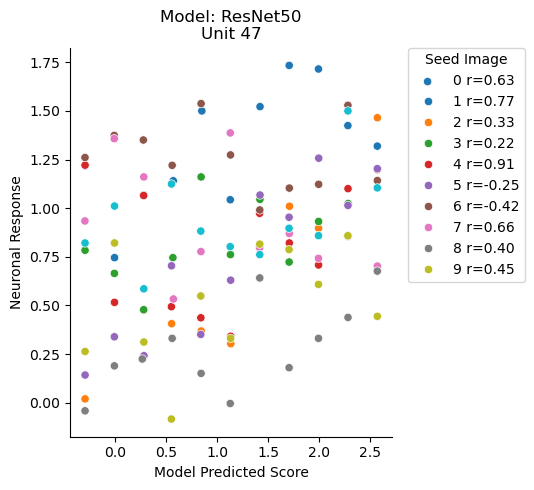

In [81]:
target_unit = 47
df_split = stim_info.query("unit_id == @target_unit and model_name == 'r50'")
plt.figure(figsize=(5.5, 5))
sns.scatterplot(data=df_split, 
                x="actual_score", 
                y=f"resp_chan{target_unit}", hue="img_id", palette="tab10")
# compute pearson correlation for different seed images 
pearson_corr = {}
annot_strs = []
for img_id in df_split.img_id.unique():
    df_split_img = df_split.query("img_id == @img_id")
    corr, pval = pearsonr(df_split_img["actual_score"], df_split_img[f"resp_chan{target_unit}"])
    pearson_corr[img_id] = corr
    annot_strs.append(f"{img_id} r={pearson_corr[img_id]:.2f}")
# pearson_corr
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Seed Image", labels=annot_strs)
plt.title(f"Model: ResNet50\nUnit {target_unit}")
plt.xlabel("Model Predicted Score")
plt.ylabel("Neuronal Response")
plt.tight_layout()
plt.show()

In [85]:

corr_label_map

{0: '0 r=0.80',
 1: '1 r=0.93',
 2: '2 r=0.89',
 3: '3 r=0.93',
 4: '4 r=0.71',
 5: '5 r=0.48',
 6: '6 r=0.90',
 7: '7 r=0.65',
 8: '8 r=0.91',
 9: '9 r=0.31'}

In [86]:
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

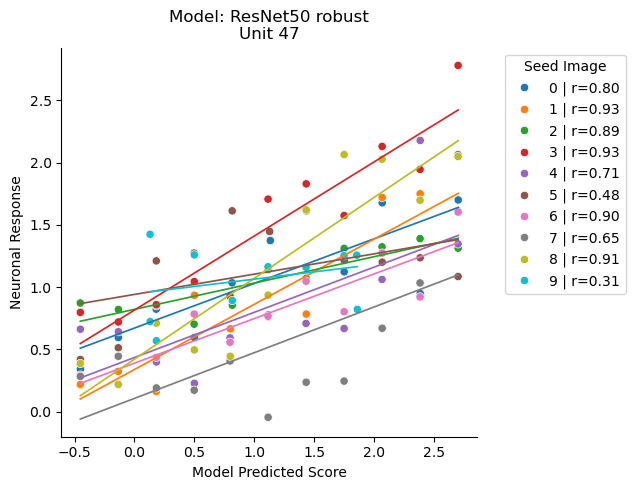

In [97]:
target_unit = 47
df_split = stim_info.query("unit_id == @target_unit and model_name == 'robust_r50'")
pearson_corr = {}
for img_id in df_split.img_id.unique():
    df_split_img = df_split.query("img_id == @img_id")
    corr, pval = pearsonr(df_split_img["actual_score"], df_split_img[f"resp_chan{target_unit}"])
    pearson_corr[img_id] = corr
plt.figure(figsize=(6.5, 5))
# Create the scatterplot
ax = sns.scatterplot(
    data=df_split, 
    x="actual_score", 
    y=f"resp_chan{target_unit}", 
    hue="img_id", 
    palette="tab10"
)

# Add regression line for each img_id with matching color
for i, img_id in enumerate(df_split.img_id.unique()):
    df_img = df_split.query("img_id == @img_id")
    color = plt.cm.tab10(i % 10)  # Get the same color as in the scatter plot
    sns.regplot(data=df_img,
        x="actual_score", 
        y=f"resp_chan{target_unit}", 
        scatter=False, ci=None, line_kws={"color": color, "lw": 1.25}, ax=ax
    )

# Grab handles and labels from the existing legend
handles, labels = ax.get_legend_handles_labels()
# The 'labels' you get here are the unique `img_id` values as Seaborn sees them.
# Create a mapping from `img_id` -> correlation string
corr_label_map = {
    f'{img_id}': f"{img_id} | r={pearson_corr[img_id]:.2f}"
    for img_id in df_split.img_id.unique()
}
# Build a new label list in the same order that Seaborn used
new_labels = [corr_label_map.get(l, l) for l in labels]
# Now pass the same handles with new labels to plt.legend()
plt.legend(handles, new_labels, title="Seed Image", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Model: ResNet50 robust\nUnit {target_unit}")
plt.xlabel("Model Predicted Score")
plt.ylabel("Neuronal Response")
plt.tight_layout()
plt.show()

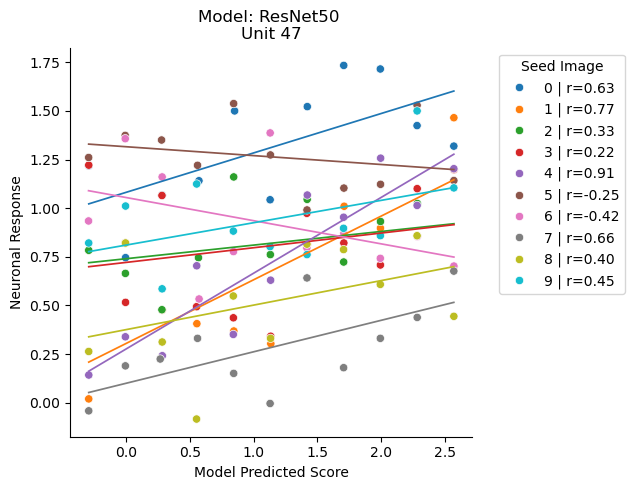

In [98]:
target_unit = 47
df_split = stim_info.query("unit_id == @target_unit and model_name == 'r50'")
pearson_corr = {}
for img_id in df_split.img_id.unique():
    df_split_img = df_split.query("img_id == @img_id")
    corr, pval = pearsonr(df_split_img["actual_score"], df_split_img[f"resp_chan{target_unit}"])
    pearson_corr[img_id] = corr
plt.figure(figsize=(6.5, 5))
# Create the scatterplot
ax = sns.scatterplot(
    data=df_split, 
    x="actual_score", 
    y=f"resp_chan{target_unit}", 
    hue="img_id", 
    palette="tab10"
)

# Add regression line for each img_id with matching color
for i, img_id in enumerate(df_split.img_id.unique()):
    df_img = df_split.query("img_id == @img_id")
    color = plt.cm.tab10(i % 10)  # Get the same color as in the scatter plot
    sns.regplot(data=df_img,
        x="actual_score", 
        y=f"resp_chan{target_unit}", 
        scatter=False, ci=None, line_kws={"color": color, "lw": 1.25}, ax=ax
    )

# Grab handles and labels from the existing legend
handles, labels = ax.get_legend_handles_labels()
# The 'labels' you get here are the unique `img_id` values as Seaborn sees them.
# Create a mapping from `img_id` -> correlation string
corr_label_map = {
    f'{img_id}': f"{img_id} | r={pearson_corr[img_id]:.2f}"
    for img_id in df_split.img_id.unique()
}
# Build a new label list in the same order that Seaborn used
new_labels = [corr_label_map.get(l, l) for l in labels]
# Now pass the same handles with new labels to plt.legend()
plt.legend(handles, new_labels, title="Seed Image", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Model: ResNet50 \nUnit {target_unit}")
plt.xlabel("Model Predicted Score")
plt.ylabel("Neuronal Response")
plt.tight_layout()
plt.show()

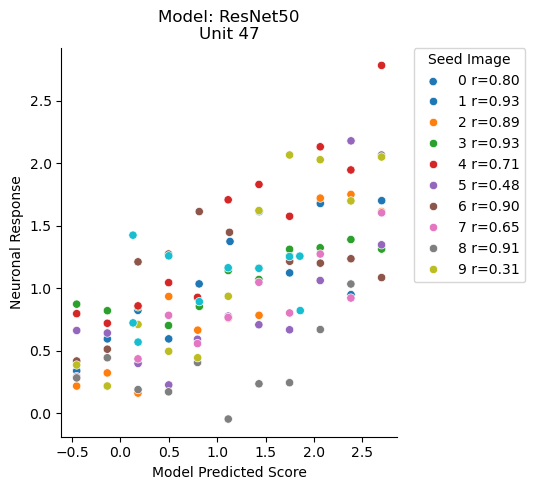

In [82]:
target_unit = 47
df_split = stim_info.query("unit_id == @target_unit and model_name == 'robust_r50'")
plt.figure(figsize=(5.5, 5))
sns.scatterplot(data=df_split, 
                x="actual_score", 
                y=f"resp_chan{target_unit}", hue="img_id", palette="tab10")
# compute pearson correlation for different seed images 
pearson_corr = {}
annot_strs = []
for img_id in df_split.img_id.unique():
    df_split_img = df_split.query("img_id == @img_id")
    corr, pval = pearsonr(df_split_img["actual_score"], df_split_img[f"resp_chan{target_unit}"])
    pearson_corr[img_id] = corr
    annot_strs.append(f"{img_id} r={pearson_corr[img_id]:.2f}")
# pearson_corr
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Seed Image", labels=annot_strs)
plt.title(f"Model: ResNet50\nUnit {target_unit}")
plt.xlabel("Model Predicted Score")
plt.ylabel("Neuronal Response")
plt.tight_layout()
plt.show()

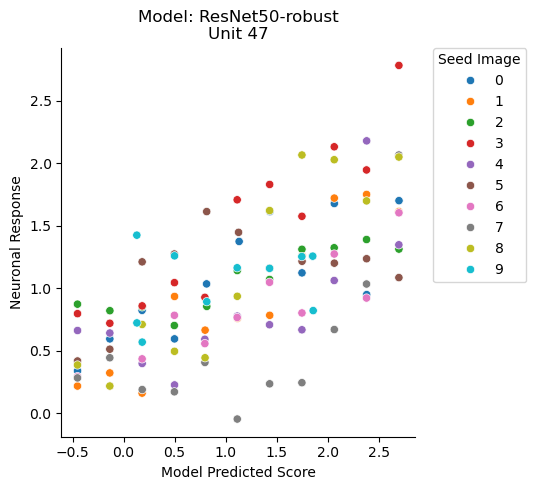

In [71]:
target_unit = 47
plt.figure(figsize=(5.5, 5))
sns.scatterplot(data=stim_info.query("unit_id == @target_unit and model_name == 'robust_r50'"), 
                x="actual_score", y=f"resp_chan{target_unit}", 
                hue="img_id", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Seed Image")
plt.title(f"Model: ResNet50-robust\nUnit {target_unit}")
plt.xlabel("Model Predicted Score")
plt.ylabel("Neuronal Response")
plt.tight_layout()
plt.show()

In [49]:
stim_info.model_name.unique()

array(['r50', 'robust_r50', nan], dtype=object)

In [18]:
fa_param_df

,filename,model_name,unit_id,img_id,target_score,actual_score
0,r50_unit_25_img_0_level_-0.36653251647949214_s...,r50,25,0,-0.366533,-0.358208
1,r50_unit_25_img_0_level_-1.0111116826534272_sc...,r50,25,0,-1.011112,-1.002852
2,r50_unit_25_img_0_level_-1.655690848827362_sco...,r50,25,0,-1.655691,-1.648388
3,r50_unit_25_img_0_level_0.2780466496944429_sco...,r50,25,0,0.278047,0.271675
4,r50_unit_25_img_0_level_0.9226258158683778_sco...,r50,25,0,0.922626,0.914070
...,...,...,...,...,...,...
1095,robust_r50_unit_8_img_9_level_2.37801055908203...,robust_r50,8,9,2.378011,2.369042
1096,robust_r50_unit_8_img_9_level_2.99351692795753...,robust_r50,8,9,2.993517,2.984022
1097,robust_r50_unit_8_img_9_level_3.60902329683303...,robust_r50,8,9,3.609023,3.599594
1098,robust_r50_unit_8_img_9_level_4.22452966570854...,robust_r50,8,9,4.224530,4.036341
